In [1]:
#Import dependencies

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import IPython
import os
from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
import nrrd
import torch
from torch.nn.functional import grid_sample
import tornado
import sys
import copy
import skimage as ski
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from STalign import STalign
import nibabel as nib
from scipy.ndimage import rotate
#from STalign.STalign import interp3d
%matplotlib widget

In [5]:
# see https://jef.works/STalign/overview.html#installation-import for installing STalign

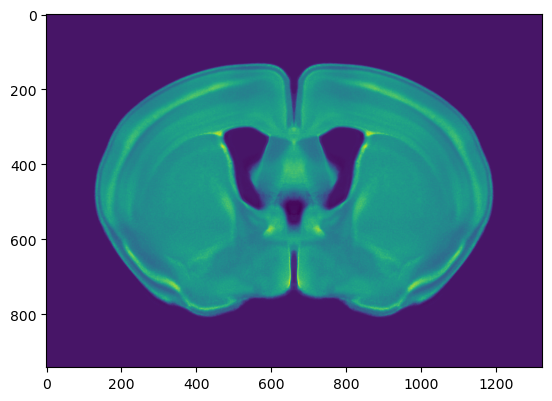

In [81]:
%matplotlib inline
##### CHANGE THIS ####
# using dapi atlas from paper: https://www.nature.com/articles/s41597-020-0570-z
# CAUTION: these are .nii files -> need to open with nibabel
img = nib.load("dapi_template_with_origin.nii").get_fdata()
label = nib.load("dapi_template_segmentation_full_with_origin.nii").get_fdata()
######################

A = np.flip(np.transpose(img,(1,2,0)),axis=(0,1))
S = np.flip(np.transpose(label,(1,2,0)),axis=(0,1))

dxA = [33.34,8.6,8.6]
nxA = A.shape
xA = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxA,dxA)]
XA = np.meshgrid(*xA,indexing='ij')

plt.imshow(A[100])
dimAtlas = A.shape


Pre-Processing

(840, 1047)
(840, 1047)
0
(840, 1047)


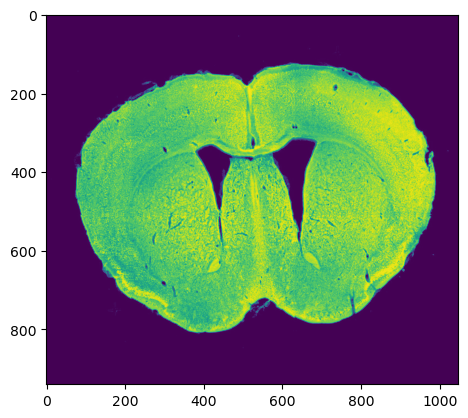

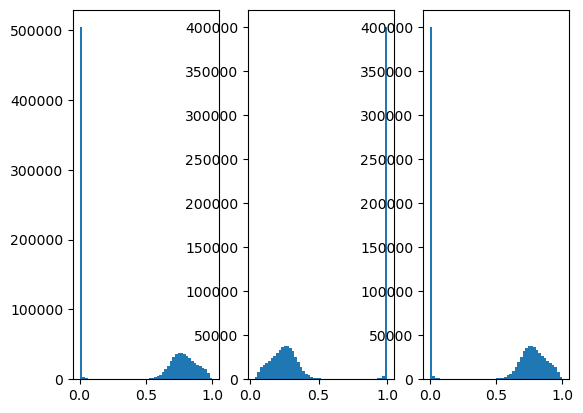

In [82]:
# Open image and preprocess

##### CHANGE THIS #####
filename = "for_STalign.jpg"
#######################

W = ski.color.rgb2gray(ski.io.imread(filename))
print(W.shape)

# downscaling
print(W.shape)
ds_factor = np.max(np.divide(W.shape, dimAtlas[1:])) #factor to downscale by
ds_factor = int(ds_factor)
print(ds_factor)
if ds_factor == 0: ds_factor=1
W_ = ski.transform.downscale_local_mean(W, (ds_factor, ds_factor)) # downsample
print(W_.shape)


#Basic preprocessing: gray-scaling and thresholding background

bg_threshold = 1

W__ = np.copy(W_)
W__ = (W__ - np.min(W__))/(np.max(W__) - np.min(W__)) #then normalize
W__ = 1-W__#bg_threshold # invert colors

im = plt.imshow(W__)

# rigid padding
### CAN CHANGE PAD ###
pad = 50
W = np.pad(W__,((pad,pad),(0,0)),'minimum')
######################

im = plt.imshow(W)


# Intensity Histogram
fig,ax = plt.subplots(1,3)
ax[0].hist(W.ravel(),bins=50);
ax[1].hist(W_.ravel(),bins=50);
ax[2].hist(W__.ravel(),bins=50);

Prep for STalign

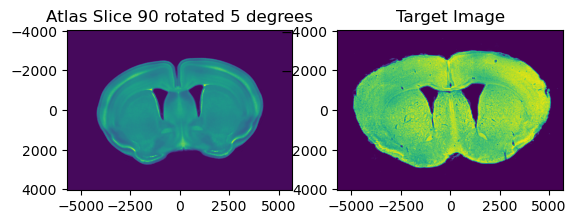

In [83]:
#find slice
#peruse through images in atlas
# Loading the atlas
import time
%matplotlib inline
from scipy.ndimage import rotate

slice = 90
theta_deg=5
fig,ax = plt.subplots(1,2)
extentA = STalign.extent_from_x(xA[1:])
ax[0].imshow(rotate(A[slice], angle=theta_deg),extent=extentA)
ax[0].set_title(f'Atlas Slice {slice} rotated {theta_deg} degrees')

ax[1].imshow(W,extent=extentA)
ax[1].set_title('Target Image')


fig.canvas.draw()

    
%matplotlib inline

In [84]:
# SETTING SOME OTHER PARAMETERS
xJ = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(W.shape,dxA[1:])]
J = W[None]/np.mean(np.abs(W))
xI = xA
I = A[None] / np.mean(np.abs(A),keepdims=True)
I = np.concatenate((I,(I-np.mean(I))**2)) # comment this line out when using stalign_no_contrast

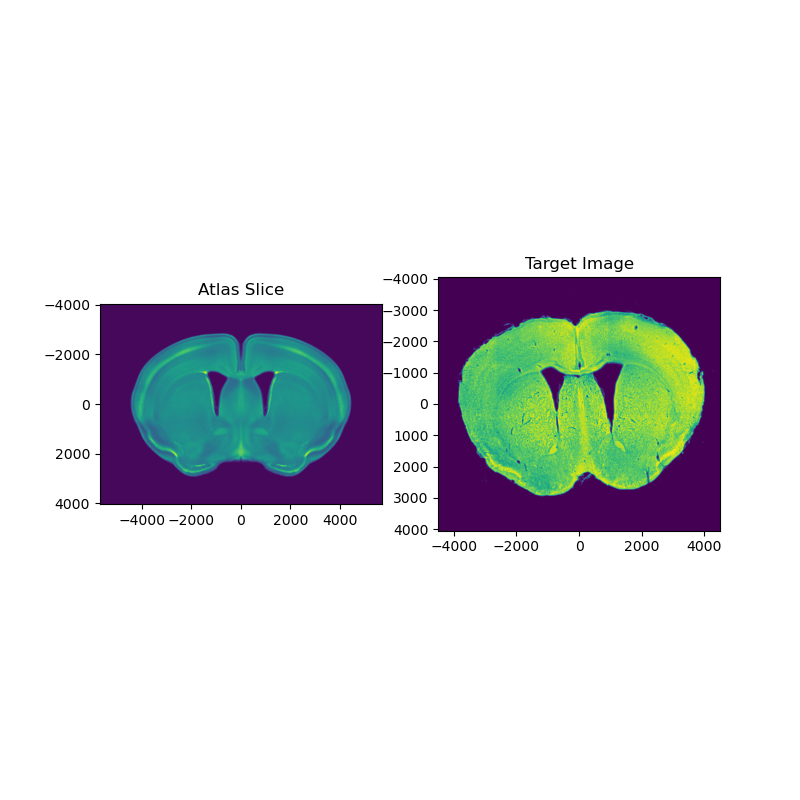

point added to source at [-2097, -1979]
point added to source at [-1424, -1257]
point added to target at [-1696, -1725]
point added to target at [-1303, -1083]
Added [-1257, -1424] and [-1083, -1303] to points list
point added to source at [-1127, -1818]
point added to source at [1432, -1262]
point added to target at [1115, -1789]
point added to target at [1482, -1276]
Added [-1262, 1432] and [-1276, 1482] to points list
point added to source at [-966, -1454]
point added to source at [-522, -1030]
point added to target at [-514, -1629]
point added to target at [-481, -931]
Added [-1030, -522] and [-931, -481] to points list
point added to source at [-359, -1737]
point added to source at [538, -1036]
point added to target at [-162, -1214]
point added to target at [430, -1013]
Added [-1036, 538] and [-1013, 430] to points list
point added to source at [-1531, -2020]
point added to source at [-1061, -1321]
point added to target at [-1440, -2108]
point added to target at [-890, -1195]
Adde

In [87]:
### POINT ANNOTATOR ###
# left side is atlas slice
# right side is target image
# use mouse left click to select pair of points on atlas and target
# right click removes the point
# enter commits points to list -> they will change to white
# backspace removes most recently committed point
# when done selecting and committing points, simply move on to next cell

%matplotlib widget
import tkinter
import copy

imgs = [A[slice], W]
extents = [STalign.extent_from_x(xI[1:]),STalign.extent_from_x(xJ)]
points = [[],[]]
new_pts = [[],[]]
fig, ax = plt.subplots(1,2, figsize=(8, 8))
pt_sz = 2

# Create a random image
points_atlas = points[0]
points_target = points[1]

def refresh(axis=None):

    # refresh both axes if no axis specified
    if type(axis) == type(None):
        refresh(0)
        refresh(1)
        return
    elif axis not in [0,1]:
        print(f"BAD CALL TO refresh(axis={axis})")
        return
    
    ax[axis].cla()
    ax[axis].imshow(imgs[axis],extent=extents[axis])
    if len(points[0]): ax[axis].scatter(np.array(points)[axis,:,2],np.array(points)[axis,:,1], color='white', s=pt_sz) # plot prev selected points in white
    plt.draw()

def onclick(event):

    if event.xdata == None: return # clicked outside of axes
    ix, iy = int(event.xdata), int(event.ydata) # get x and y data of pt
    iz = 0
    msg = f'[{ix}, {iy}]'

    axis = -1
    # based on where user clicked, set axis and update output msg
    if event.inaxes == ax[0]: 
        axis = 0
        iz = xI[0][slice] # z value corresponding to slice
        msg = "source at " + msg
    elif event.inaxes == ax[1]:
        axis = 1
        msg = "target at " + msg
    else: print("ERROR: clicked outside axes")

    refresh(axis) # refresh that axis to clear out any previously clicked on pts that were not committed

    if event.button == 1: # left click means add point at mouse location
        ax[axis].scatter([ix],[iy], color='red', s=pt_sz)
        new_pts[axis] = [iz, iy, ix]
        msg = 'point added to ' + msg
    elif event.button == 3: # right click means remove previously created point
        new_pts[axis] = []
        msg = 'point removed from ' + msg

    print(msg)
            
    plt.draw()



def on_press(event):
    if event.key == 'enter': # enter key used to commit selected points to points list

        if not len(new_pts[0])*len(new_pts[1]): # if missing a point in either axis, throw error
            print("ERROR: attempted landmark save with one or more points missing!")
            return

        # add new points to list, notify user, and clear out new points list
        points[0].append(new_pts[0])
        points[1].append(new_pts[1])
        print(f"Added {new_pts[0][1:]} and {new_pts[1][1:]} to points list")
        new_pts[0] = []
        new_pts[1] = []
        refresh() # refresh both axes

    if event.key == 'backspace': # backspace key used to remove recently committed point
        if len(points[0]) == 0: return # if no points to remove, simply return
        print(f'Removed [{points[0][-1][1:]}] and [{points[1][-1][1:]}]') # user msg
        
        # remove last pair of poins
        points[0].pop(-1)
        points[1].pop(-1)
        refresh() # refresh both axes


cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.canvas.mpl_connect('key_press_event', on_press)

refresh()
ax[0].set_title('Atlas Slice')
ax[1].set_title('Target Image')

plt.show()


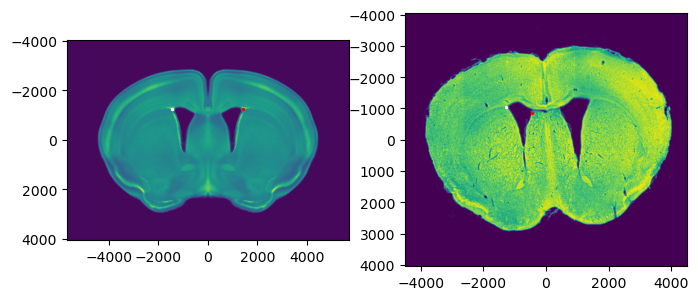

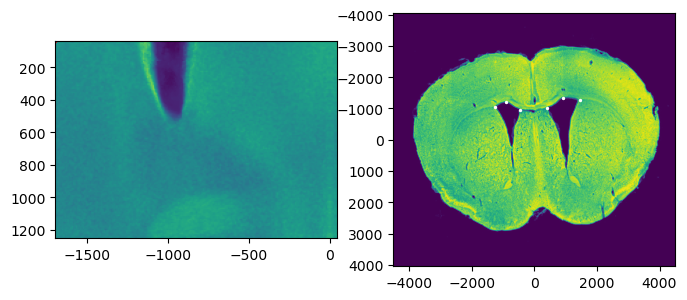

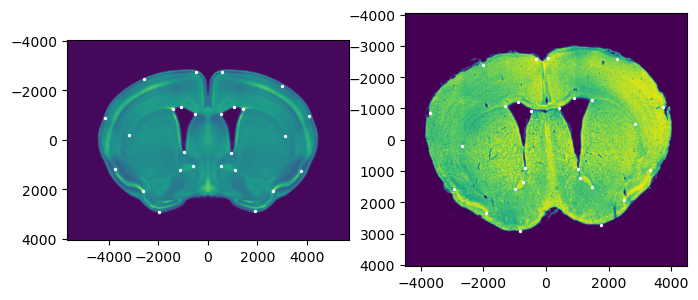

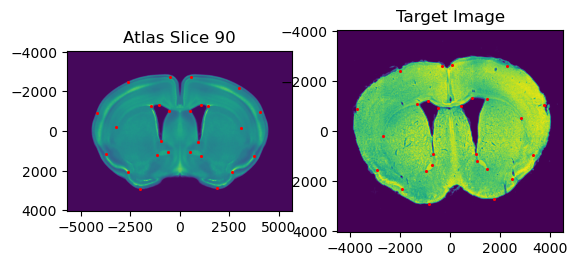

In [88]:
### PLOT ANNOTATIONS TO ENSURE ACCURACY ###
%matplotlib inline
points_atlas = np.array(points_atlas)
points_target = np.array(points_target)

#print(points_atlas, points_target)
#Li,Ti = STalign.L_T_from_points(points_atlas[:,1:],points_target[:,1:])
fig,ax = plt.subplots(1,2)
ax[0].imshow(A[slice], extent=extents[0])
ax[0].set_title(f'Atlas Slice {slice}')
ax[0].scatter(points_atlas[:,2],points_atlas[:,1],color='red', s=1.5)

ax[1].imshow(W, extent=extents[1])
ax[1].set_title('Target Image')
ax[1].scatter(points_target[:,2],points_target[:,1],color='red', s=1.5)

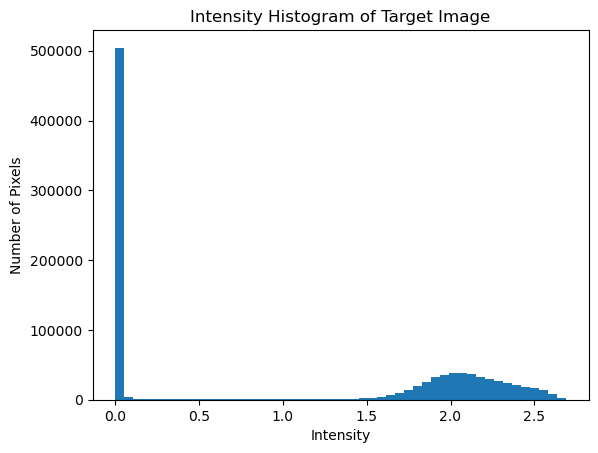

In [89]:
# Intensity Histogram - use this for selecting sigmaA,sigmaM,sigmaB,muA,muB
fig,ax = plt.subplots()
ax.hist(J.ravel(), bins=50)
plt.xlabel('Intensity');
plt.ylabel('Number of Pixels');
plt.title('Intensity Histogram of Target Image');

In [90]:
#### SETTING PARAMETERS FOR STALIGN ####
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

sigmaA = .1 #standard deviation of artifact intensities
sigmaB = .1 #standard deviation of background intensities
sigmaM = .4 #standard deviation of matching tissue intenities

muA = torch.tensor([2.6,2.6,2.6],device=device) #average of artifact intensities

muB = torch.tensor([0,0,0],device=device) #average of background intensities

scale_x = 1
scale_y = 1
scale_z = 1
theta0 = torch.tensor((np.pi/180)*theta_deg)

# get an initial guess
if 'Ti' in locals():
    T = np.array([-xI[0][slice],np.mean(xJ[0])-(Ti[0]*scale_y),np.mean(xJ[1])-(Ti[1]*scale_x)])

else:
    T = np.array([-xI[0][slice],np.mean(xJ[0]),np.mean(xJ[1])])

print(T)
L = np.array([[1.0,0.0,0.0],
             [0.0,np.cos(theta0),-np.sin(theta0)],
              [0.0,np.sin(theta0),np.cos(theta0)]])
scale_atlas = np.array([[scale_z,0,0],
                        [0,scale_y,0],
                        [0,0,scale_z]])
L = np.matmul(L,scale_atlas)

[ 4.83430000e+02 -1.23846087e-13  0.00000000e+00]


In [68]:
### FUNCTION DEFINITION for LDDMM

def LDDMM_3D_to_slice(xI,I,xJ,J,pointsI=None,pointsJ=None,
        L=None,T=None,A=None,v=None,xv=None,
        a=500.0,p=2.0,expand=1.25,nt=3,
        niter=5000,diffeo_start=0, epL=1e-6, epT=1e1, epV=1e3,
        sigmaM=1.0,sigmaB=2.0,sigmaA=5.0,sigmaR=1e8,sigmaP=2e1,
        device='cpu',dtype=torch.float64, muA=None, muB = None):

    if muA is None:
        estimate_muA = True
    else:
        estimate_muA = False
    if muB is None:
        estimate_muB = True
    else:
        estimate_muB = False
        
    # check initial inputs and convert to torch
    if A is not None:
        # if we specify an A
        if L is not None or T is not None:
            raise Exception('If specifying A, you must not specify L or T')
        L = torch.tensor(A[:3,:3],device=device,dtype=dtype,requires_grad=True)
        T = torch.tensor(A[:3,-1],device=device,dtype=dtype,requires_grad=True)   
    else:
        # if we do not specify A                
        if L is None: L = torch.eye(3,device=device,dtype=dtype,requires_grad=True)
        if T is None: T = torch.zeros(3,device=device,dtype=dtype,requires_grad=True)
    
    L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
    T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
    # change to torch
    I = torch.tensor(I,device=device,dtype=dtype)                         
    J = torch.tensor(J,device=device,dtype=dtype)
    if J.ndim == 3:
        J = J[:,None] # add a z slice dimension


    if v is not None and xv is not None:
        v = torch.tensor(v,device=device,dtype=dtype,requires_grad=True)
        xv = [torch.tensor(x,device=device,dtype=dtype) for x in xv]
        XV = torch.stack(torch.meshgrid(xv),-1)
        nt = v.shape[0]        
    elif v is None and xv is None:
        minv = torch.as_tensor([x[0] for x in xI],device=device,dtype=dtype)
        maxv = torch.as_tensor([x[-1] for x in xI],device=device,dtype=dtype)
        minv,maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0],device=device,dtype=dtype)[...,None]*(maxv-minv)*expand
        xv = [torch.arange(m,M,a*0.5,device=device,dtype=dtype) for m,M in zip(minv,maxv)]
        XV = torch.stack(torch.meshgrid(xv),-1)
        v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2],XV.shape[3]),device=device,dtype=dtype,requires_grad=True)
        
    else:
        raise Exception(f'If inputting an initial v, must input both xv and v')
    extentV = STalign.extent_from_x(xv[1:])
    dv = torch.as_tensor([x[1]-x[0] for x in xv],device=device,dtype=dtype)
    
    fv = [torch.arange(n,device=device,dtype=dtype)/n/d for n,d in zip(XV.shape,dv)]
    extentF = STalign.extent_from_x(fv[1:])
    FV = torch.stack(torch.meshgrid(fv),-1)
    LL = (1.0 + 2.0*a**2* torch.sum( (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0)

    K = 1.0/LL
    #fig,ax = plt.subplots()
    #ax.imshow(K,vmin=0.0,vmax=0.1,extent=extentF)
    
    #fig,ax = plt.subplots()
    #ax.imshow(K[0].cpu())
    DV = torch.prod(dv)
    Ki = torch.fft.ifftn(K).real
    fig,ax = plt.subplots()
    ax.imshow(Ki[Ki.shape[0]//2].clone().detach().cpu().numpy(),vmin=0.0,extent=extentV)
    ax.set_title('smoothing kernel')
    fig.canvas.draw()

    # steps
    epL = torch.tensor(epL,device=device,dtype=dtype)
    epT = torch.tensor(epT,device=device,dtype=dtype)

    # initialize weights
    WM = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.5
    WB = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.4
    WA = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.1

    # locations of pixels
    extentI = STalign.extent_from_x(xI[1:]) 
    xI = [torch.tensor(x,device=device,dtype=dtype) for x in xI]
    if len(xJ) == 2:
        xJ = [[0.0],xJ[0],xJ[1]]    
    extentJ = STalign.extent_from_x(xJ[1:])
    xJ = [torch.tensor(x,device=device,dtype=dtype) for x in xJ]
    XI = torch.stack(torch.meshgrid(*xI,indexing='ij'),-1)
    XJ = torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1)
    dJ = [x[1]-x[0] for x in xJ[1:]]
    
    # metric TODO
    '''
    g = torch.zeros((12,12))
    count = 0
    for i in range(12):
        Ei = (torch.arange(16)==i).reshape((4,4))*1.0
        EiXI = (Ei[:3,:3]@XI[...,None])[...,0] + Ei[:3,-1]
        for j in range(12):
            Ej = (torch.arange(16)==j).reshape((4,4))*1.0
            EjXI = (Ej[:3,:3]@XI[...,None])[...,0] + Ej[:3,-1]
            g[i,j] = torch.mean(torch.sum(EiXI*EjXI,-1))

    gi = torch.inverse(g)
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(g)
    ax[0].set_title('Metric') 
    ax[1].imshow(gi)    
    ax[1].set_title('Inverse metric') 
    fig.canvas.draw()
    '''

    # a figure
    fig,ax = plt.subplots(2,3)
    ax = ax.ravel()
    if type(pointsI) != type(None): figE,axE = plt.subplots(1,4)
    else: figE,axE = plt.subplots(1,3)
    axE = axE.ravel()
    Esave = []
    # zero gradients
    try:
        L.grad.zero_()
    except:
        pass
    try:
        T.grad.zero_()
    except:
        pass

    if pointsI is None and pointsJ is None:
        pointsI = torch.zeros((0,2),device=J.device,dtype=J.dtype)
        pointsJ = torch.zeros((0,2),device=J.device,dtype=J.dtype) 
    elif (pointsI is None and pointsJ is not None) or (pointsJ is None and pointsI is not None):
        raise Exception('Must specify corresponding sets of points or none at all')
    else:
        pointsI = torch.tensor(pointsI,device=J.device,dtype=J.dtype)
        pointsJ = torch.tensor(pointsJ,device=J.device,dtype=J.dtype)


    for it in range(niter):
        torch.autograd.set_detect_anomaly(True)
        # make A
        A = STalign.to_A_3D(L,T)

        # Ai
        Ai = torch.linalg.inv(A)
        # transform sample points        
        Xs = (Ai[:-1,:-1]@XJ[...,None])[...,0] + Ai[:-1,-1]
        # now diffeo, not semilagrange here
        for t in range(nt-1,-1,-1):
            #print(Xs.shape)
            Xs = Xs + STalign.interp3D(xv,-v[t].permute(3,0,1,2),Xs.permute(3,0,1,2)).permute(1,2,3,0)/nt
        # # and points (not in 3D)        
        #print(np.shape(pointsI))
        
        pointsIt = torch.clone(pointsI)
        if pointsIt.shape[0] >0:
            for t in range(nt):

                #print("before interp: " +str(pointsIt))   
                #print(pointsIt.T[...,None].shape)

                #print(f'before transformation: {pointsIt_t}')
                pointsIt += (STalign.interp3D(xv,v[t].permute(3,0,1,2),pointsIt.T[...,None,None])[...,0,0].T/nt)
                #print(f'after interp: {pointsIt_t}')
                #print(f'pointsIt becomes {pointsIt}')
            
            pointsIt = (A[:-1,:-1]@pointsIt.T + A[:-1,-1][...,None]).T
    
            #print(f'pointsIt becomes {pointsIt}')
        
       
        # transform image
        AI = STalign.interp3D(xI,I,Xs.permute(3,0,1,2),padding_mode="border")

        # transform the contrast
        #B = torch.ones(1+AI.shape[0],AI.shape[1]*AI.shape[2]*AI.shape[3],device=AI.device,dtype=AI.dtype)
        #B[1:AI.shape[0]+1] = AI.reshape(AI.shape[0],-1)
        #B = torch.ones(10,AI.shape[1]*AI.shape[2],device=AI.device,dtype=AI.dtype)
        #B[1:4] = AI.reshape(AI.shape[0],-1)
        #B[4] = (AI[0][None]**2).reshape(1,-1)
        #B[5] = (AI[1][None]**2).reshape(1,-1)
        #B[6] = (AI[2][None]**2).reshape(1,-1)
        #B[7] = (AI[0][None]*AI[1][None]).reshape(1,-1)
        #B[8] = (AI[0][None]*AI[2][None]).reshape(1,-1)
        #B[9] = (AI[1][None]*AI[2][None]).reshape(1,-1)
        #with torch.no_grad():    
        #    BB = B@(B*WM.ravel()).T
        #    BJ = B@((J*WM).reshape(J.shape[0],J.shape [1]*J.shape[2]*J.shape[3])).T
         #   small = 0.1
         #   coeffs = torch.linalg.solve(BB + small*torch.eye(BB.shape[0],device=BB.device,dtype=BB.dtype),BJ)
        #fAI = ((B.T@coeffs).T).reshape(J.shape)
        fAI = AI
        # objective function
        EM = torch.sum((fAI - J)**2*WM)/2.0/sigmaM**2
        ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
        #if pointsIt.shape[0]>0: EP = torch.sum((pointsIt_t - pointsJt)**2)/2.0/sigmaP**2
            
        E = EM + ER #+ EP
        tosave = [E.item(), EM.item(), ER.item()]
        #print(tosave)
        if pointsIt.shape[0]>0:
            EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
            E += EP
            tosave.append(EP.item())
        

        Esave.append( tosave )
        # gradient update
        '''try:
            L.grad.zero_()
        except:
            pass
        try:
            T.grad.zero_()
        except:
            pass
        try:
            v.grad.zero_()
        except:
            pass'''
        E.backward()

        with torch.no_grad():            
            L -= (epL/(1.0 + (it>=diffeo_start)*9))*L.grad
            T -= (epT/(1.0 + (it>=diffeo_start)*9))*T.grad

            #L.grad.zero_()
            #T.grad.zero_()

            # v grad
            vgrad = v.grad
            # smooth it            
            if it >= diffeo_start:
                vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad,dim=(1,2,3))*K[...,None],dim=(1,2,3)).real
                v -= vgrad*epV
            #v.grad.zero_()

        # update weights
        if not it%5:
            with torch.no_grad():
                # M step for these params
                if estimate_muA:
                    muA = torch.sum(WA*J,dim=(-1,-2,-3))/torch.sum(WA)
                if estimate_muB:
                    muB = torch.sum(WB*J,dim=(-1,-2,-3))/torch.sum(WB)
                #if it <= 200:
                #    muA = torch.tensor([0.75,0.77,0.79],device=J.device,dtype=J.dtype)
                #    muB = torch.ones(J.shape[0],device=J.device,dtype=J.dtype)*0.96

                #if it >= 50:

                #    W = torch.stack((WM,WA,WB))
                #    pi = torch.sum(W,dim=(1,2,3))
                #    pi += torch.max(pi)*1e-6
               #     pi /= torch.sum(pi)


                    # now the E step, update the weights
                #    WM = pi[0]* torch.exp( -torch.sum((fAI - J)**2,0)/2.0/sigmaM**2 )/np.sqrt(2.0*np.pi*sigmaM**2)**J.shape[0]
                #    WA = pi[1]* torch.exp( -torch.sum((muA[...,None,None,None] - J)**2,0)/2.0/sigmaA**2 )/np.sqrt(2.0*np.pi*sigmaA**2)**J.shape[0]
                #    WB = pi[2]* torch.exp( -torch.sum((muB[...,None,None,None] - J)**2,0)/2.0/sigmaB**2 )/np.sqrt(2.0*np.pi*sigmaB**2)**J.shape[0]
                 #   WS = WM+WB+WA
                 #   WS += torch.max(WS)*1e-6
                #    WM /= WS
                 #   WB /= WS
                 #   WA /= WS


        # draw
        if not it%10:
            ax[0].cla()
            Ishow = ((AI-torch.amin(AI,(1,2,3))[...,None,None])/(torch.amax(AI,(1,2,3))-torch.amin(AI,(1,2,3)))[...,None,None,None]).permute(1,2,3,0).clone().detach().cpu()
            ax[0].imshow(  Ishow[0,...,0] ,extent=extentJ)
            if pointsIt.shape[0] >0: ax[0].scatter(pointsIt[...,2].clone().detach().cpu(),pointsIt[...,1].clone().detach().cpu(),s=1,color='orange')
            ax[0].set_title('space tformed source')

            ax[1].cla()    
            Ishow = STalign.clip(fAI.permute(1,2,3,0).clone().detach()/torch.max(J).item()).cpu()
            ax[1].imshow(Ishow[0,...,0],extent=extentJ,vmin=0,vmax=1)
            #ax[1].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[1].set_title('contrast tformed source')
            
            ax[5].cla()
            Ishow = STalign.clip( (fAI - J)/(torch.max(J).item())*3.0  ).permute(1,2,3,0).clone().detach().cpu()*0.5+0.5
            ax[5].imshow(Ishow[0,...,0],extent=extentJ)
            #ax[5].scatter(pointsIt[:,2].clone().detach().cpu(),pointsIt[:,1].clone().detach().cpu(),s=1,color='red')
            #ax[5].scatter(pointsJt[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu(),,s=1,color='yellow')
            ax[5].set_title('Error')

            ax[2].cla()
            Ishow = J.permute(1,2,3,0).cpu()/torch.max(J).item()
            ax[2].imshow(Ishow[0,...,0],extent=extentJ,vmin=0,vmax=1)
            if pointsIt.shape[0] >0: ax[2].scatter(pointsJ[...,2].clone().detach().cpu(),pointsJ[...,1].clone().detach().cpu(),s=1,color='red')
            ax[2].set_title('Target')

            ax[4].cla()
            ax[4].imshow(STalign.clip(torch.stack((WM,WA,WB),-1).clone().detach()).cpu()[0],extent=extentJ)
            #ax[4].scatter(pointsIt[:,2].clone().detach().cpu(),pointsIt[:,1].clone().detach().cpu())
            #ax[4].scatter(pointsJt[:,2].clone().detach().cpu(),pointsJt[:,1].clone().detach().cpu())

            ax[4].set_title('Weights')


            toshow = v[0].clone().detach().cpu() # initial velocity, components are rgb
            toshow /= torch.max(torch.abs(toshow))
            toshow = toshow*0.5+0.5
  #toshow = torch.cat((toshow,torch.zeros_like(toshow[...,0][...,None])),-1)   
            ax[3].cla()
            ax[3].imshow(STalign.clip(toshow)[toshow.shape[0]//2],extent=extentV)
            ax[3].set_title('velocity')
            
            axE[0].cla()
            axE[0].plot(Esave)
            axE[0].legend(['E','EM','ER','EP'])
            axE[0].set_yscale('log')
            axE[1].cla()
            axE[1].plot([e[:2] for e in Esave])
            axE[1].legend(['E','EM'])
            axE[1].set_yscale('log')
            axE[2].cla()
            axE[2].plot([e[2] for e in Esave])
            axE[2].legend(['ER'])
            axE[2].set_yscale('log')
            if pointsIt.shape[0] >0:
                axE[3].cla()
                axE[3].plot([e[3] for e in Esave])
                axE[3].legend(['EP'])
                axE[3].set_yscale('log')
            
            
            fig.canvas.draw()
            figE.canvas.draw()

    #print(pointsJ,pointsI)
    #print(pointsJt,pointsIt)

    return {
        'A': A.clone().detach(), 
        'v': v.clone().detach(), 
        'xv': xv, 
        'WM': WM.clone().detach(),
        'WB': WB.clone().detach(),
        'WA': WA.clone().detach(),
        'Xs': Xs.clone().detach()
    }

C:\Users\kebsc\AppData\Local\Temp\ipykernel_21988\1074581482.py:330: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')


CPU times: total: 5min 26s
Wall time: 5min 11s


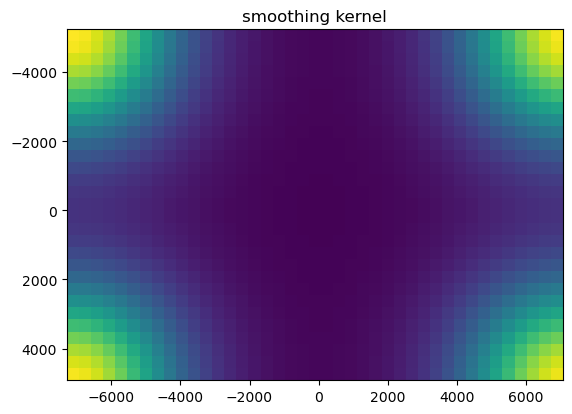

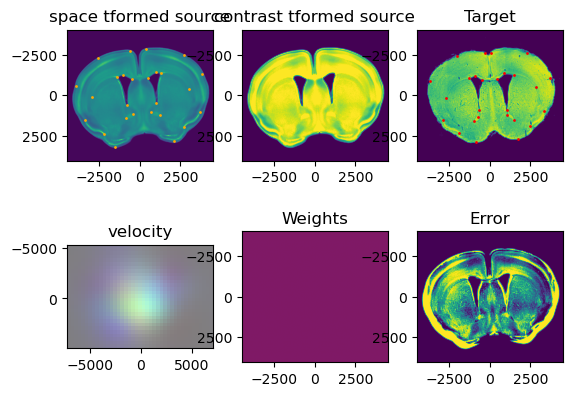

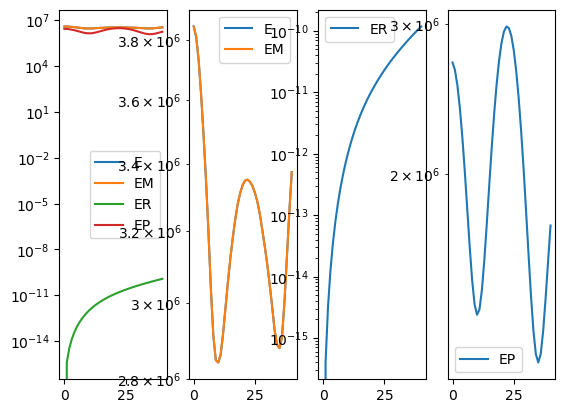

In [97]:
%%time
# run LDDMM

#tried:
#nt=4, niter=25
#nt=8, niter=25
#nt=8, niter=50
#nt=40, niter=10
#nt=40, niter=50
#nt=12,niter=75
#nt=12,niter=100
#nt=12,niter=100, sigmaP=1e2
#nt=12,niter=100, sigmaP=1
#nt=12,niter=100, sigmaP=1, many more points landmarked
#nt=12,niter=200, sigmaP=1, many more points landmarked
#nt=12,niter=100, sigmaP=1e-1, many more points landmarked
#nt=12,niter=100, sigmaP=1e-1, many MORE points landmarked
#nt=12,niter=100, sigmaP=1, many MORE points landmarked
#nt=12,niter=100, sigmaP=1, better slice, ~20 pts marked
#nt=12,niter=100, sigmaP=1, better slice, ~20 pts marked, a=500
#nt=12,niter=50, sigmaP=1, better slice, ~20 pts marked, a=700
#nt=12,niter=50, sigmaP=1, better slice, ~20 pts marked, a=700, epV = 1e-1
#nt=12,niter=50, sigmaP=1, better slice, ~20 pts marked, a=700, epV = 1e-3
#nt=12,niter=50, sigmaP=1, better slice, ~20 pts marked, a=700, epV = 1e-7

#returns mat = affine transform, v = velocity, xv = pixel locations of velocity points
transform = LDDMM_3D_to_slice(
    xI,I,xJ,J,
    T=T,L=L,
    nt=12,niter=50,
    device=device,
    sigmaA = sigmaA, #standard deviation of artifact intensities
    sigmaB = sigmaB, #standard deviation of background intensities
    sigmaM = sigmaM, #standard deviation of matching tissue intenities
    sigmaP = 1,
    sigmaR = 1e8,
    muA = muA, #average of artifact intensities
    muB = muB, #average of background intensities
    pointsI=points_atlas,
    pointsJ=points_target,
    
    a = 700,
    epL = 1e-9,
    epT = 1e-9,
    epV = 1e-7
)
%matplotlib inline
#[1, 3, 18, 21, 29]]

c:\Users\kebsc\anaconda3\envs\rishi_cuda\Lib\site-packages\stalign-1.0-py3.12.egg\STalign\STalign.py:1725: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)
c:\Users\kebsc\anaconda3\envs\rishi_cuda\Lib\site-packages\stalign-1.0-py3.12.egg\STalign\STalign.py:1726: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v)
c:\Users\kebsc\anaconda3\envs\rishi_cuda\Lib\site-packages\stalign-1.0-py3.12.egg\STalign\STalign.py:1738: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XJ = torch.tensor(XJ)


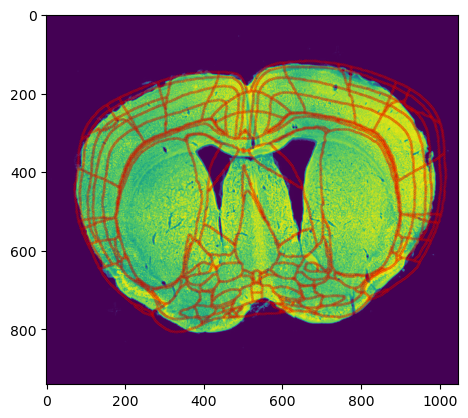

In [78]:
A = transform['A']
v = transform['v']
xv = transform['xv']
Xs = transform['Xs']

vol = L
dxL = dxA
nL = vol.shape
xL = [np.arange(n)*d - (n-1)*d/2 for n,d in zip(nL,dxL)]

# next chose points to sample on
res = 10.0
XJ = np.stack(np.meshgrid(np.zeros(1),xJ[0],xJ[1],indexing='ij'),-1)
tform = STalign.build_transform3D(xv,v,A,direction='b',XJ=torch.tensor(XJ,device=A.device))

AphiL = STalign.interp3D(
        xL,
        torch.tensor(vol[None].astype(np.float64),dtype=torch.float64,device=tform.device),
        tform.permute(-1,0,1,2),
        mode='nearest',)[0,0].cpu().int()

region_graph = AphiL.numpy()

brain_regions_id = np.unique(region_graph)
brain_regions_id = np.delete(brain_regions_id,0)

### GENERAL BOUNDARY VISUALIZATION ####

boundX = []
boundY = []
for x in range(region_graph.shape[1]):
    for y in range(region_graph.shape[0]):
        ### for each point, look at neighbors, if neighbor is different add to boundary points
        addToBound = False
        for xi in range(max(0, x-1), min(W.shape[1], x+2)):
            for yi in range(max(0,y-1), min(W.shape[0], y+2)):
                if region_graph[yi][xi] != region_graph[y][x]: addToBound = True
        if addToBound: 
            boundX.append(x)
            boundY.append(y)

%matplotlib inline
fig,ax = plt.subplots()
ax.imshow(W)
ax.scatter(boundX,boundY, s=0.001, color='red')

Saving Results

In [72]:
# Saving all relavant variables
import pickle

# Saving transform
#### CHANE THIS ####
filename = 'temp.pickle'
###################
with open(filename,'wb') as file:
    pickle.dump(transform, file)
    print('transform check')
    pickle.dump(W,file)
    print('W check')
    pickle.dump(xJ,file)
print("stored")

transform check
W check
stored


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\kebsc\anaconda3\envs\rishi_cuda\lib\site-packages\stalign-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\kebsc\anaconda3\envs\rishi_cuda\lib\site-packages\tornado-6.2-py3.12-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\kebsc\anaconda3\envs\rishi_cuda\lib\site-packages\yarg-0.1.9-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
